In [209]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB


In [210]:
# Load dataset
df = pd.read_csv('after_preprocess.csv')
df.head()

,Unnamed: 0,Review_Text,Label,Review_Text_processed
0,0,"sir okay armygreen shorts nice""""",1,"['sir', 'okay', 'armygreen', 'shorts', 'nice']"
1,1,"di pareha yong mga size nila may sobrang liit""""",0,"['di', 'pareha', 'yong', 'size', 'sobrang', 'l..."
2,2,super worth it ang ganda Sombra grabi order na...,1,"['super', 'worth', 'ganda', 'sombra', 'grabi',..."
3,3,"ganda po salamat""""",1,"['ganda', 'po', 'salamat']"
4,4,"maayos pagkadeliver maganda den sya""""",0,"['ayos', 'kadeliver', 'anda', 'den', 'sya']"


In [211]:
# Review_Text_processed is a list of tokens per row
df['review_length'] = df['Review_Text_processed'].apply(lambda x: len(x.split()))
tfidf = TfidfVectorizer(ngram_range=(1, 2))
df.head()


,Unnamed: 0,Review_Text,Label,Review_Text_processed,review_length
0,0,"sir okay armygreen shorts nice""""",1,"['sir', 'okay', 'armygreen', 'shorts', 'nice']",5
1,1,"di pareha yong mga size nila may sobrang liit""""",0,"['di', 'pareha', 'yong', 'size', 'sobrang', 'l...",6
2,2,super worth it ang ganda Sombra grabi order na...,1,"['super', 'worth', 'ganda', 'sombra', 'grabi',...",14
3,3,"ganda po salamat""""",1,"['ganda', 'po', 'salamat']",3
4,4,"maayos pagkadeliver maganda den sya""""",0,"['ayos', 'kadeliver', 'anda', 'den', 'sya']",5


In [212]:
# Convert tokenized list to joined string for later vectorization
df['Review_Text_joined'] = df['Review_Text_processed'].apply(
    lambda tokens: ' '.join(eval(tokens)) if isinstance(tokens, str) else ' '.join(tokens)
)

In [213]:
# Add text length for visualization
df['length'] = df['Review_Text_processed'].apply(len)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             100 non-null    int64 
 1   Review_Text            100 non-null    object
 2   Label                  100 non-null    int64 
 3   Review_Text_processed  100 non-null    object
 4   review_length          100 non-null    int64 
 5   Review_Text_joined     100 non-null    object
 6   length                 100 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 5.6+ KB


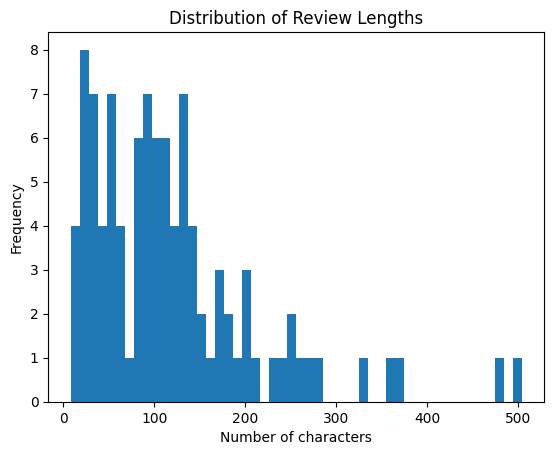

In [214]:
# Plot histogram of review lengths
plt.hist(df['length'], bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.show()

In [215]:
# Grouped descriptive statistics
print(df.groupby('Label').describe())

      Unnamed: 0                                                   \
           count   mean        std  min    25%   50%    75%   max   
Label                                                               
0           50.0  47.54  28.019825  1.0  25.25  49.0  65.75  97.0   
1           50.0  51.46  30.125730  0.0  25.00  50.0  77.75  99.0   

      review_length         ...              length                           \
              count   mean  ...    75%   max  count    mean        std   min   
Label                       ...                                                
0              50.0  16.82  ...  21.75  55.0   50.0  151.94  97.619923  34.0   
1              50.0   8.92  ...  11.00  41.0   50.0   86.28  80.826102   8.0   

                                   
        25%    50%     75%    max  
Label                              
0      80.0  132.5  198.25  504.0  
1      30.0   84.0  107.75  482.0  

[2 rows x 24 columns]


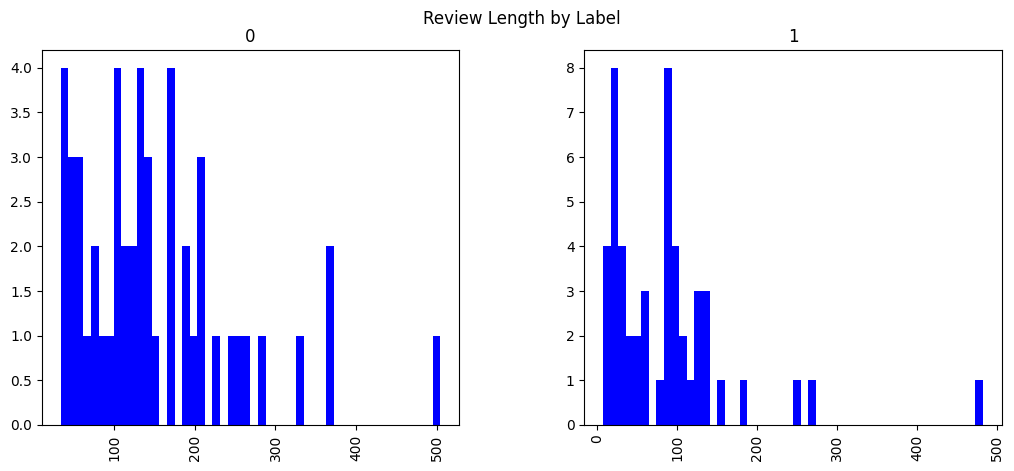

In [216]:
# Histograms per class
df.hist(column='length', by='Label', bins=50, color='blue', figsize=(12, 5))
plt.suptitle('Review Length by Label')
plt.show()

In [217]:
# Bag of Words
bow_transformer = CountVectorizer()
bow_transformer.fit(df['Review_Text_joined'])

CountVectorizer()

In [218]:
print("Total Vocabulary Size:", len(bow_transformer.vocabulary_))

Total Vocabulary Size: 677


In [219]:
# Inspect one review
review4 = df['Review_Text_joined'].iloc[3]
bow_msg4 = bow_transformer.transform([review4])
print("BoW representation of review 4:", bow_msg4)
print("Shape:", bow_msg4.shape)

BoW representation of review 4: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3 stored elements and shape (1, 677)>
  Coords	Values
  (0, 199)	1
  (0, 463)	1
  (0, 511)	1
Shape: (1, 677)


In [220]:
print(bow_transformer.get_feature_names_out()[199])
print(bow_transformer.get_feature_names_out()[463])
print(bow_transformer.get_feature_names_out()[511])

ganda
po
salamat


In [221]:
# Full BoW for all reviews
bow_reviews = bow_transformer.transform(df['Review_Text_joined'])

In [222]:
print("Shape of Bag of Words:", bow_reviews.shape)
print("Non-zero entries:", bow_reviews.nnz)
print("Sparsity:", np.round((bow_reviews.nnz / (bow_reviews.shape[0] * bow_reviews.shape[1])) * 100, 2), "%")

Shape of Bag of Words: (100, 677)
Non-zero entries: 1159
Sparsity: 1.71 %


In [223]:
# TF-IDF transformation
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_msg4 = tfidf_transformer.transform(bow_msg4)

In [224]:
# Example TF-IDF scores
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['thank']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['ganda']])

2.7247487589450947
2.976063187226001


In [225]:
# Full TF-IDF matrix
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("TF-IDF shape:", tfidf_reviews.shape)
print("TF-IDF ndim:", tfidf_reviews.ndim)

TF-IDF shape: (100, 677)
TF-IDF ndim: 2


## Creating training and testing data

In [226]:
# Train/test split
review_train, review_test, label_train, label_test = train_test_split(
    df['Review_Text_joined'], df['Label'], test_size=0.35, random_state=42
)

In [227]:
# Pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer()),          # Converts text into token counts
    ('tfidf', TfidfTransformer()),       # Applies TF-IDF weighting
    ('classifier', MultinomialNB())      # Trains a Naive Bayes classifier
])

## Training and testing Multinomial Naive Bayes Algorithm on the preprocessed data

In [228]:
# Train model
pipeline.fit(review_train, label_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [229]:
df['Label'].value_counts()


Label
1    50
0    50
Name: count, dtype: int64

In [230]:
# Predict and evaluate
predictions = pipeline.predict(review_test)

print('Classification Report:\n', classification_report(label_test, predictions))
print('Confusion Matrix:\n', confusion_matrix(label_test, predictions))
print('Accuracy Score:', accuracy_score(label_test, predictions))
print('Model Prediction Accuracy:', str(np.round(accuracy_score(label_test, predictions) * 100, 2)) + '%')

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.72      0.72      0.72        18

    accuracy                           0.71        35
   macro avg       0.71      0.71      0.71        35
weighted avg       0.71      0.71      0.71        35

Confusion Matrix:
 [[12  5]
 [ 5 13]]
Accuracy Score: 0.7142857142857143
Model Prediction Accuracy: 71.43%
